In [1]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras import backend as K

In [2]:
train_dir = './train'
batch_size = 32
img_height = 240
img_width = 240

IMG_SIZE = (img_width, img_height)
#(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

In [3]:
train_set = tf.keras.utils.image_dataset_from_directory(
train_dir,
validation_split = 0.2,
seed = 123,
batch_size = batch_size,
image_size =IMG_SIZE,
subset='training')

valid_set = tf.keras.utils.image_dataset_from_directory(
train_dir,
validation_split = 0.2,
seed = 123,
batch_size = batch_size,
image_size =IMG_SIZE,
subset='validation')

Found 711 files belonging to 3 classes.
Using 569 files for training.
Found 711 files belonging to 3 classes.
Using 142 files for validation.


In [4]:
test_dir = './test'
test_set = tf.keras.utils.image_dataset_from_directory(test_dir, shuffle=True,
                                                       validation_split=0.2, subset='training',
                                                       seed=123, batch_size=batch_size, image_size=IMG_SIZE)

Found 114 files belonging to 3 classes.
Using 92 files for training.


In [5]:
class_names = train_set.class_names
print(class_names)

['adidas', 'converse', 'nike']


In [6]:
train_datagen = ImageDataGenerator(rescale = 1./ 255, rotation_range = 40, width_shift_range = 0.2, height_shift_range = 0.2,
                                  shear_range = 0.2, zoom_range = 0.2, horizontal_flip = True, fill_mode = 'nearest', validation_split=0.2)

test_datagen = ImageDataGenerator(rescale = 1./ 255)

train_data = train_datagen.flow_from_directory(
    train_dir,
    target_size=(240, 240),
    batch_size=32,
    class_mode='categorical',
    subset='training',
    shuffle = False) # set as training data

valid_data = train_datagen.flow_from_directory(
    train_dir, # same directory as training data
    target_size=(240, 240),
    batch_size=32,
    class_mode='categorical',
    subset='validation') # set as validation data

##train_data = train_datagen.flow_from_directory(directory = train_dir, batch_size = 32, target_size = (240,240), class_mode = "categorical", shuffle = False)
test_data = test_datagen.flow_from_directory(directory = test_dir, batch_size = 32, target_size = (240,240), class_mode = "categorical")

Found 570 images belonging to 3 classes.
Found 141 images belonging to 3 classes.
Found 114 images belonging to 3 classes.


### Base Model

In [7]:
preprocess_input = tf.keras.applications.resnet50.preprocess_input

In [9]:
base_model = tf.keras.applications.ResNet50V2(include_top = False)
base_model.trainable = False

inputs = tf.keras.layers.Input(shape = (240, 240, 3), name = 'InputLayer')
x = base_model(inputs)
x = tf.keras.layers.GlobalAveragePooling2D(name = 'global_average_pooling_layer')(x)
x = tf.keras.layers.Dense(512, activation = 'softmax', name = 'Dense_layer')(x)
x = Dropout(0.2)(x)
outputs = tf.keras.layers.Dense(3, activation = 'softmax', name = 'output_layer')(x)

In [10]:
def plot_loss_curves(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.ylabel('Accuracy')
    plt.ylim([min(plt.ylim()),1])
    plt.title('Training and Validation Accuracy')

    plt.subplot(2, 1, 2)
    plt.plot(loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.ylabel('Cross Entropy')
    plt.ylim([0,1.0])
    plt.title('Training and Validation Loss')
    plt.xlabel('epoch')
    plt.show()

In [11]:
#Callback to save the best model
callbacks_list = [
    keras.callbacks.ModelCheckpoint(
        filepath='model.h5',
        monitor='val_accuracy', save_best_only=True, verbose=1),
    keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10,verbose=1)
]

In [12]:
epochs = 80

model = tf.keras.Model(inputs, outputs)
model.compile(loss = 'categorical_crossentropy', optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001), metrics = ['accuracy'])
history = model.fit(train_data, epochs = epochs, steps_per_epoch = len(train_data), 
                    callbacks = callbacks_list,
                    validation_data = valid_data, validation_steps = int(0.25 * len(valid_data)))

Epoch 1/80
18/18 [==============================] - ETA: 0s - loss: 1.1020 - accuracy: 0.3035
Epoch 1: val_accuracy improved from -inf to 0.43750, saving model to model.h5
18/18 [==============================] - 114s 6s/step - loss: 1.1020 - accuracy: 0.3035 - val_loss: 1.0931 - val_accuracy: 0.4375
Epoch 2/80
18/18 [==============================] - ETA: 0s - loss: 1.0989 - accuracy: 0.3965
Epoch 2: val_accuracy improved from 0.43750 to 0.65625, saving model to model.h5
18/18 [==============================] - 95s 5s/step - loss: 1.0989 - accuracy: 0.3965 - val_loss: 1.0861 - val_accuracy: 0.6562
Epoch 3/80
18/18 [==============================] - ETA: 0s - loss: 1.0875 - accuracy: 0.6000
Epoch 3: val_accuracy did not improve from 0.65625
18/18 [==============================] - 95s 5s/step - loss: 1.0875 - accuracy: 0.6000 - val_loss: 1.0750 - val_accuracy: 0.5625
Epoch 4/80
18/18 [==============================] - ETA: 0s - loss: 1.0803 - accuracy: 0.4526
Epoch 4: val_accuracy did 

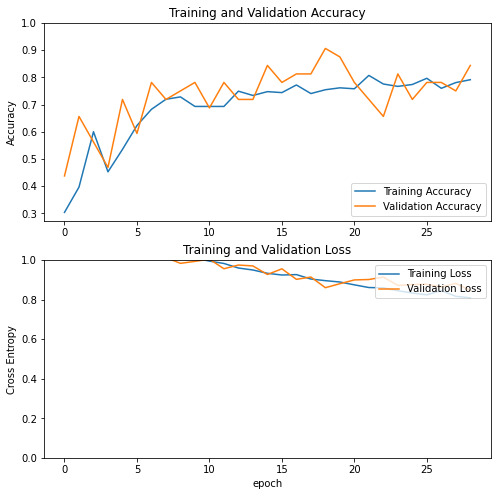

In [13]:
plot_loss_curves(history)

In [14]:
loss0, accuracy0 = model.evaluate(valid_data)

5/5 [==============================] - 23s 4s/step - loss: 0.8344 - accuracy: 0.8014


In [15]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 0.83
initial accuracy: 0.80


### Fine-tuning

In [16]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

Number of layers in the base model:  190


In [17]:
model.compile(loss = 'categorical_crossentropy', optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001), metrics = ['accuracy'])


In [18]:
fine_tune_epochs = 20
total_epochs =  epochs + fine_tune_epochs

#Callback to save the best model
callbacks_list = [
    keras.callbacks.ModelCheckpoint(
        filepath='model.h5',
        monitor='val_accuracy', save_best_only=True, verbose=1),
    keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10,verbose=1)
]

history_fine = model.fit(train_data,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         callbacks = callbacks_list,
                         validation_data=valid_data)

Epoch 29/100
18/18 [==============================] - ETA: 0s - loss: 0.7951 - accuracy: 0.7789
Epoch 29: val_accuracy improved from -inf to 0.82270, saving model to model.h5
18/18 [==============================] - 133s 7s/step - loss: 0.7951 - accuracy: 0.7789 - val_loss: 0.8184 - val_accuracy: 0.8227
Epoch 30/100
18/18 [==============================] - ETA: 0s - loss: 0.7852 - accuracy: 0.7912
Epoch 30: val_accuracy did not improve from 0.82270
18/18 [==============================] - 113s 6s/step - loss: 0.7852 - accuracy: 0.7912 - val_loss: 0.8228 - val_accuracy: 0.8085
Epoch 31/100
18/18 [==============================] - ETA: 0s - loss: 0.7723 - accuracy: 0.8070
Epoch 31: val_accuracy did not improve from 0.82270
18/18 [==============================] - 113s 6s/step - loss: 0.7723 - accuracy: 0.8070 - val_loss: 0.8259 - val_accuracy: 0.7730
Epoch 32/100
18/18 [==============================] - ETA: 0s - loss: 0.7812 - accuracy: 0.8088
Epoch 32: val_accuracy did not improve from

In [19]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

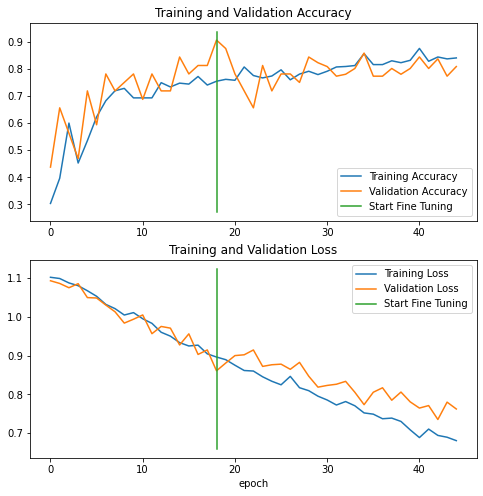

In [20]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
#plt.ylim([0.8, 1])
plt.plot([18,18],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
#plt.ylim([0, 1.0])
plt.plot([18,18],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [21]:
print("We got an accuracy of {:.2f}%".format(model.evaluate(test_data)[1]*100))

4/4 [==============================] - 17s 4s/step - loss: 0.7553 - accuracy: 0.8158
We got an accuracy of 81.58%


In [22]:
loss, accuracy = model.evaluate(test_data)
print('Test accuracy :', accuracy)

4/4 [==============================] - 17s 4s/step - loss: 0.7553 - accuracy: 0.8158
Test accuracy : 0.8157894611358643


In [23]:
image_batch, label_batch = test_data.next()
predictions = model.predict_on_batch(image_batch)
y_pred = []
predictions = tf.nn.softmax(predictions)

print('Labels:\n', label_batch)

for i in range(0, len(label_batch)):
    y_pred.append(np.argmax(predictions[i]))
    
print('Predictions:\n',np.array(y_pred))

Labels:
 [[0. 0. 1.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 1. 0.]]
Predictions:
 [2 1 2 2 2 0 1 1 0 2 2 0 0 0 2 0 2 2 1 1 1 0 0 1 1 0 1 1 1 0 2 1]


TypeError: only integer scalar arrays can be converted to a scalar index

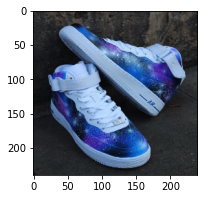

In [24]:
plt.figure(figsize=(10, 14))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image_batch[i])
    plt.title(f"Original: {class_names[label_batch[i]]}\n\n Predicted: {class_names[y_pred[i]]}")
    plt.axis("off")

In [25]:
import math

number_of_examples = len(test_data.filenames)
number_of_generator_calls = math.ceil(number_of_examples / (1.0 * batch_size)) 
# 1.0 above is to skip integer division

test_labels = []

for i in range(0,int(number_of_generator_calls)):
    test_labels.extend(np.array(test_data[i][1]))

In [26]:
test_data.labels

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2])

In [27]:
test_data.class_indices.keys()

dict_keys(['adidas', 'converse', 'nike'])

In [28]:
print(test_data.class_indices)

{'adidas': 0, 'converse': 1, 'nike': 2}


C:\Users\saras\anaconda3\lib\site-packages\matplotlib\text.py:1163: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


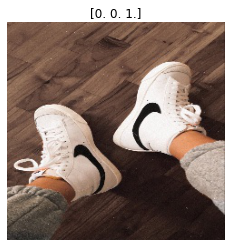

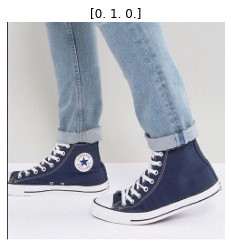

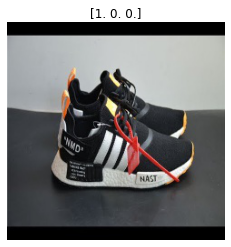

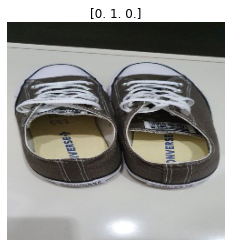

In [29]:
x,y= test_data.next()
for i in range(0,4):
    image = x[i]
    plt.imshow(image)
    label = y[i]
    plt.title (label)
    #plt.title(f"Original: {class_names[y[i]]}\n\n Predicted: {class_names[y_pred[i]]}")
    plt.axis("off")
    plt.show()